<div style="background-color: #c1f2a5">


# PS4

In this problem set, you will implement multidimensional scaling (MDS) from scratch. You may use standard matrix/vector libraries (e.g. numpy) but you must implement two dimensional MDS itself on your own and not use an existing software package. MDS attempts to find an arrangement of points such that the distances between points match human-judged similarities. 

# Instructions



Remember to do your problem set in Python 3. Fill in `#YOUR CODE HERE`.

Make sure: 
- that all plots are scaled in such a way that you can see what is going on (while still respecting specific plotting instructions) 
- that the general patterns are fairly represented.
- to label all x- and y-axes, and to include a title.
    
</div>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
# to import the data set
from scipy.io import loadmat



## Import and examine data

We will be using a data set from Romney, A. K., Brewer, D. D., & Batchelder, W. H. (1993). Predicting Clustering from Semantic Structure. Psychological Science, 4(1), 28-34, via https://faculty.sites.uci.edu/mdlee/similarity-data/. The data set is saved in PS4_dataset.mat, and includes pairwise similarity measures between 21 sports. Make sure that the PS notebook and the data set are in the same directory!

As our first step, we will download and examine the data:


In [3]:
data_set = loadmat('PS4_dataset.mat')
similarity = data_set['similarity']
sport_names = data_set['sport_names']

As we can see, our data contains information for 21 different sports as listed below: 

In [4]:
print(sport_names)

['football  ' 'baseball  ' 'basketball' 'tennis    ' 'softball  '
 'canoeing  ' 'handball  ' 'rugby     ' 'hockey    ' 'ice hockey'
 'swimming  ' 'track     ' 'boxing    ' 'volleyball' 'lacrosse  '
 'skiing    ' 'golf      ' 'polo      ' 'surfing   ' 'wrestling '
 'gymnastics']


We also have a similarity matrix for each sport, which gives us the psychological similarity of that sport with all the other sports in the data:

In [5]:
#Look at the first similarity matrix, which corresponds to football's similarity with itself and all other sports
print(similarity[0])

[1.         0.18518519 0.48148148 0.14814815 0.74074074 0.07407407
 0.77777778 0.77777778 0.88888889 0.11111111 0.14814815 0.40740741
 0.85185185 0.92592593 0.7037037  0.03703704 0.         0.74074074
 0.07407407 0.48148148 0.03703704]


## Q1. Visualize similarity [5pts, HELP]

Plot the "similarity" measures from the data as a heatmap. Don't forget to:

       1)Label the heatmap's rows and columns with the corresponding sport (rotate the x-axis labels by 45 degrees so that the labels are readable)

       2)Add a title to your figure (e.g. similarity)

       3)Add a colorbar. Limit the colobar values between 0 and 1.

       4)Use default colormap

       5)Upload figure PS4_Q1.png to gradescope.

Hint - look up matplotlib's imshow. 

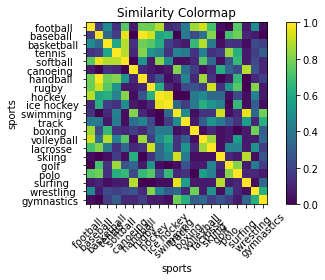

In [6]:
#YOUR CODE HERE

figure, axis = plt.subplots()

figure = plt.imshow(similarity).figure  # generate colormap

axis.set_title("Similarity Colormap")
axis.set_xlabel("sports")
axis.set_ylabel("sports")

axis.set_xticks(range(21))
axis.set_xticklabels(sport_names) # add x-axis labels
plt.xticks(rotation=45)  # rotate x-axis labels 45 degrees

axis.set_yticks(range(21))
axis.set_yticklabels(sport_names)

plt.colorbar()  # add color bar
plt.tight_layout()  # make room for the x-axis labels so that they are not cut off when savefig

figure.savefig('PS4_Q1.png')

## Q2. Distance [2 pts, SOLO]

To implement MDS, we need a measure of psychological **distance**. The dataset includes measures of similarity, not distance. 

Here we will use *d = 1-s* as a  method to transform similarity to distance.  

Write a function that converts all similarity measures in the dataset into distances, using the above provided transformation method. Function should return the output called distance (Hint: this variable will be used as an input in some of the functions you'll write in the following questions).

Plot a scatterplot of the dataset's distances (x axis) against their similarity (y axis). Label your figure.

Upload figure PS4_Q2.png to gradescope.


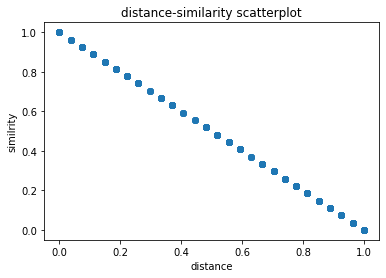

In [8]:
#YOUR CODE HERE
def sim_to_dis(similarity): 
    converter = lambda x: 1 - x
    vfunc = np.vectorize(converter)
    return vfunc(similarity)

distance = sim_to_dis(similarity)


figure, axis = plt.subplots()
axis.scatter(distance, similarity)
axis.set_title("distance-similarity scatterplot")
axis.set_xlabel("distance")
axis.set_ylabel("similrity")


figure.savefig('PS4_Q2.png')

In [7]:
# test
distance

array([[0.        , 0.81481481, 0.51851852, 0.85185185, 0.25925926,
        0.92592593, 0.22222222, 0.22222222, 0.11111111, 0.88888889,
        0.85185185, 0.59259259, 0.14814815, 0.07407407, 0.2962963 ,
        0.96296296, 1.        , 0.25925926, 0.92592593, 0.51851852,
        0.96296296],
       [0.81481481, 0.        , 0.66666667, 0.81481481, 0.03703704,
        1.        , 0.        , 0.07407407, 0.40740741, 0.37037037,
        1.        , 0.59259259, 0.77777778, 0.62962963, 0.18518519,
        1.        , 0.2962963 , 0.22222222, 0.88888889, 0.92592593,
        1.        ],
       [0.51851852, 0.66666667, 0.        , 0.40740741, 0.11111111,
        0.85185185, 0.22222222, 0.25925926, 0.37037037, 0.81481481,
        0.88888889, 0.92592593, 0.33333333, 0.11111111, 0.59259259,
        0.96296296, 0.85185185, 0.85185185, 0.96296296, 0.77777778,
        0.81481481],
       [0.85185185, 0.81481481, 0.40740741, 0.        , 0.11111111,
        0.88888889, 0.18518519, 0.48148148, 0.5555555

## Q3. Stress [5 pts, SOLO] 

To perform MDS, we will try to find, for each sport i, a position $p_i=(x_i,y_i)$ in the 2d space that captures the participants’ similarities. To do so, we will build an algorithm that minimizes the stress. We’ll define stress slightly differently than in class- the squared difference between psychological distance $\psi_{ij}= (1-s_{ij})$ and the MDS distance in 2D space: 

$$ \mathrm{Stress \ S} = \sum_{i > j} (\psi_{ij} - dist(p_i,p_j))^2$$

Where $\psi$ is the psychological distance between sport i and sport j that was reported by subjects, and *dist(pi,pj)* corresponds to the **Euclidean distance**:$\sqrt{(x_i-x_j)^2 + (y_i-y_j)^2}$ 

Write a function that computes the Euclidean Distance between two points $p_1$ and $p2$. Then, write a function that takes a $(n,2)$ (n=number of sports) matrix of $(x,y)$ positions for each sport, and computes the stress based on the equation above, using your Euclidean Distance function. 

Copy the StressCalc function into gradescope.

In [8]:
def EuclideanDistance(p1,p2):
    ''' Takes positions defined by p1 and p2, and returns a euclidean distance value (single number).
    Implement EQ equation provided in the question. Hint: if p1=p2, the function should return the value of 0'''
    #YOUR CODE HERE
    ED = math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
    return ED

In [9]:
def StressCalc(positions, distance):
    ''' Takes positions (n,2) and (n,n) matrix of distance measures
    (You will use the distance matrix from Q2). 
    Uses these distances and the EuclideanDistance function above which computes ED based on positions
    to calculate the Stress between psychological and ED distances, according to the provided formula.''' 
    
    #YOUR CODE HERE
    stress = 0
    
    for i in range(21):
        for j in range(i):
            stress += (distance[i, j] - EuclideanDistance(positions[i], positions[j]))**2
            
    return stress

In [10]:
# Test case! 
'''
Test case for StressCalc: create an array of positions, where each entry is 1.
Use this positions matrix and distance matrix from Q2 to call StressCalc function
'''

positions = np.ones((len(similarity),2))
print(['Stress value should be 111.57. Output stress value is: ' + str(StressCalc(positions,distance))])


['Stress value should be 111.57. Output stress value is: 111.57201646090526']


## Q4. Gradient [10 pts, HELP]
To minimize the stress, we will numerically compute the gradient using a multidimensional version of the simple rule for derivatives:

$$ \frac{df}{dp}(p) = \frac{f(p+\delta)-f(p-\delta)}{2\delta}$$

where $\delta$ takes on a small value, and $f$ is the stress function you wrote in the previous question. To compute the gradient, we will compute this approximate derivative with respect to each coordinate of each point.

Write a function that takes an n-by-2 matrix (n=number of sports) of (x,y) positions for each sport and computes the gradient (i.e. applies the numerical rule above to each coordinate location). This should return an n-by-2 gradient matrix.


Use $\delta$ = 0.01

Copy your code into gradescope.


In [11]:
delta = .01
positions = np.random.rand(len(similarity),2)

#YOUR CODE HERE

def GradientCalc(delta, positions):
    gradient =  positions.copy()
    for i in range(len(positions)):
        for j in range(2):
            add, minus = positions.copy(), positions.copy()
            add[i, j] += delta
            minus[i, j] -= delta
            gradient[i, j] = (StressCalc(add, distance) - StressCalc(minus, distance)) / (2 * delta)
    return gradient


In [12]:
# test
p = np.empty([21, 2])
p[:, 0] = np.arange(0, 21 * 0.04, 0.04)
p[:, 1] = np.arange(0, 21 * 0.04, 0.04)
print(GradientCalc(delta, p))

[[-0.68020791 -0.68020791]
 [-0.87514248 -0.87514248]
 [ 0.59914467  0.59914467]
 [-0.18202357 -0.18202357]
 [ 5.4107495   5.4107495 ]
 [ 0.19049116  0.19049116]
 [ 5.84757414  5.84757414]
 [ 1.40731651  1.40731651]
 [ 3.66072792  3.66072792]
 [-0.00993765 -0.00993765]
 [-2.72152721 -2.72152721]
 [-1.09938372 -1.09938372]
 [ 0.63571347  0.63571347]
 [ 2.27212316  2.27212316]
 [ 1.57913754  1.57913754]
 [-3.0160832  -3.0160832 ]
 [-3.42491469 -3.42491469]
 [ 2.32535082  2.32535082]
 [-3.84274313 -3.84274313]
 [-3.41030456 -3.41030456]
 [-4.66606076 -4.66606076]]


## Q5.1 MDS [10 pts, HELP]

Write the MDS code: the code that follows a gradient in order to find positions that minimize the stress. Start from a random position, and be sure to take small steps in the direction of the gradient (e.g.  α*gradient, with step size  α=0.01), to find a set of positions that minimizes the stress. Use 100 steps of gradient descent.

Copy your code in gradescope.

In [13]:
#YOUR CODE HERE

alpha = 0.01


def mds(delta, alpha):
    positions = np.random.rand(len(similarity),2)
    stress = []
    for _ in range(100):
        gradient = GradientCalc(delta, positions)
        positions -= gradient * alpha
        stress.append(StressCalc(positions, distance))
    return positions, stress
    
    
positions, stress_lst = mds(delta, alpha)

print(positions)
print(stress_lst)


[[ 0.1613372   0.72636532]
 [ 0.28259961  0.2662863 ]
 [ 0.03038004  0.50989154]
 [ 0.37793454  0.05353888]
 [ 0.11444234  0.30118771]
 [ 1.13053653  0.35368429]
 [ 0.14191714  0.17572045]
 [ 0.31224457  0.70585395]
 [ 0.11405186  0.67301577]
 [ 0.57757299  0.39264022]
 [ 1.09627456  0.58675138]
 [ 0.87546297  0.69472868]
 [ 0.28728639  1.08638646]
 [ 0.12029262  0.42817922]
 [ 0.39570762  0.62440158]
 [ 1.14102906  0.52042617]
 [ 0.6195077  -0.03298539]
 [ 0.43209241  0.14273207]
 [ 1.18025804  0.51428486]
 [ 0.48222282  1.02189163]
 [ 0.8709376   0.98111557]]
[30.881760780118867, 29.223560452461136, 28.07464702651832, 27.25309216267214, 26.63427799998545, 26.14251355853695, 25.726260797179805, 25.348029165596603, 24.97830078751989, 24.591366417890622, 24.161052400079182, 23.653327964406294, 23.054841896246977, 22.43334833002554, 21.859852999383893, 21.35499774059986, 20.909718242926658, 20.505851840775485, 20.125896784844002, 19.75651082310916, 19.389128207206475, 19.018525146666747,

## Q5.2 [5 pts, SOLO]

Plot the names of sports at the resulting coordinates.Hint: look up axis.text for plotting the sports names.

Upload PS4_Q5_2.png in gradescope.

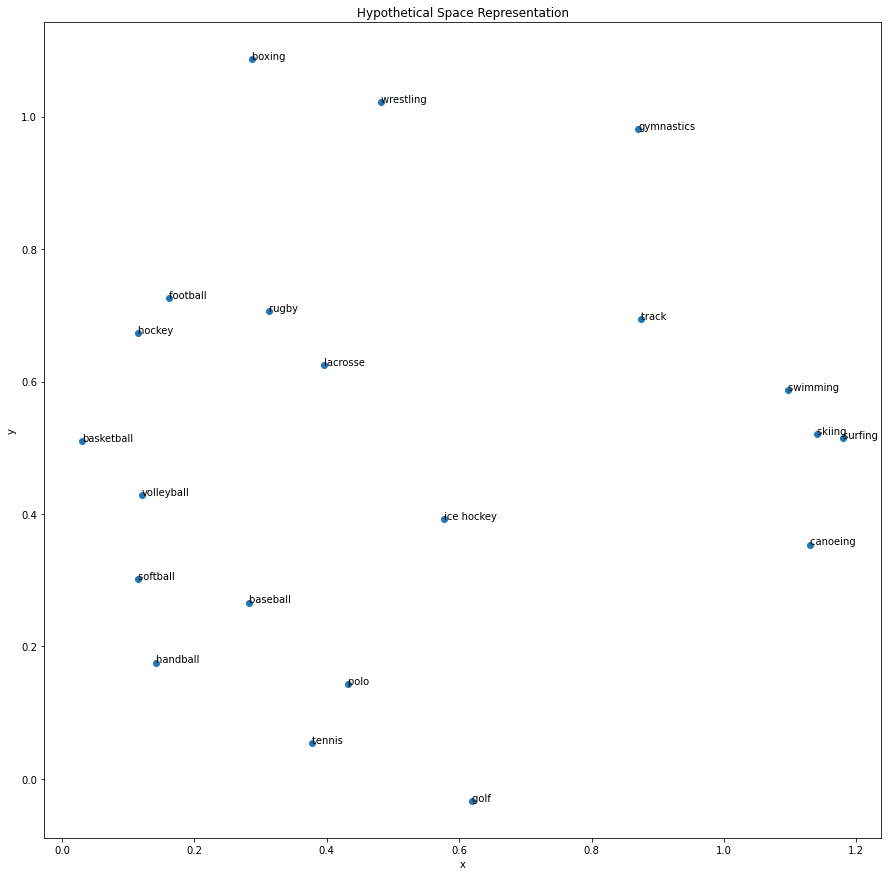

In [14]:
#YOUR CODE HERE

figure, axis = plt.subplots(figsize=(15,15))

axis.scatter(positions[:, 0], positions[:, 1])
for i in range(21):
    axis.text(positions[i, 0], positions[i, 1], sport_names[i])

axis.set_title("Hypothetical Space Representation")
axis.set_xlabel("x")
axis.set_ylabel("y")


figure.savefig('PS4_Q5_2.png')

## Q5.3 [5 pts, SOLO]
Plot the stress as a function of step number (x axis = step number, y axis= stress).

Upload PS4_Q5_3 in gradescope.

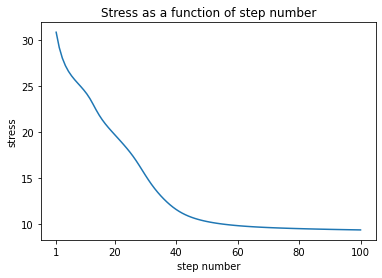

In [15]:
#YOUR CODE HERE

figure, axis = plt.subplots()

steps = np.arange(1, 100 + 1)
axis.plot(steps, stress_lst)
axis.set_xlabel("step number")
axis.set_ylabel("stress")
axis.set_title("Stress as a function of step number")
axis.set_xticks([1, 20, 40, 60, 80, 100])


figure.savefig('PS4_Q5_3.png')

## Q6. Validation [5pts, SOLO] 

Make a scatter plot of the distances obtained by running your MDS function vs. people's reported distances *d=(1-s)*. 

Upload PS4_Q6.png to gradescope. 

Briefly describe what a good and bad MDS-psychological distance relationship would look like, and whether yours is good or bad. Enter your response in gradescope.


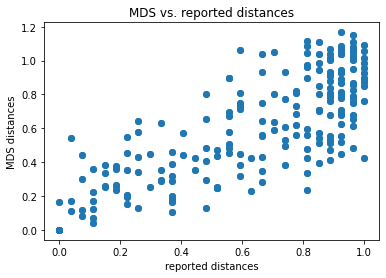

In [16]:
#YOUR CODE HERE

def DistanceCalc(positions):
    distance = np.empty([21, 21])
    for i in range(21):
        for j in range(21):
            distance[i, j] = EuclideanDistance(positions[i, :], positions[j, :])
    return distance
    
hypo_distance = DistanceCalc(positions)


figure, axis = plt.subplots()

axis.scatter(distance, hypo_distance)

axis.set_title("MDS vs. reported distances")
axis.set_xlabel("reported distances")
axis.set_ylabel("MDS distances")


figure.savefig('PS4_Q6.png')

## Q7.1 Iterating MDS [3pts, SOLO]

Run your MDS code 9 times, and plot the corresponding final positions in a figure with subplots in a 3x3 grid. Indicate the code iteration number in each subplot title. Scale the figure size using figsize=(15,15). 

Are they all the same or not? Why? Enter your response in gradescope.

Upload PS4_Q7_1.png in gradescope.

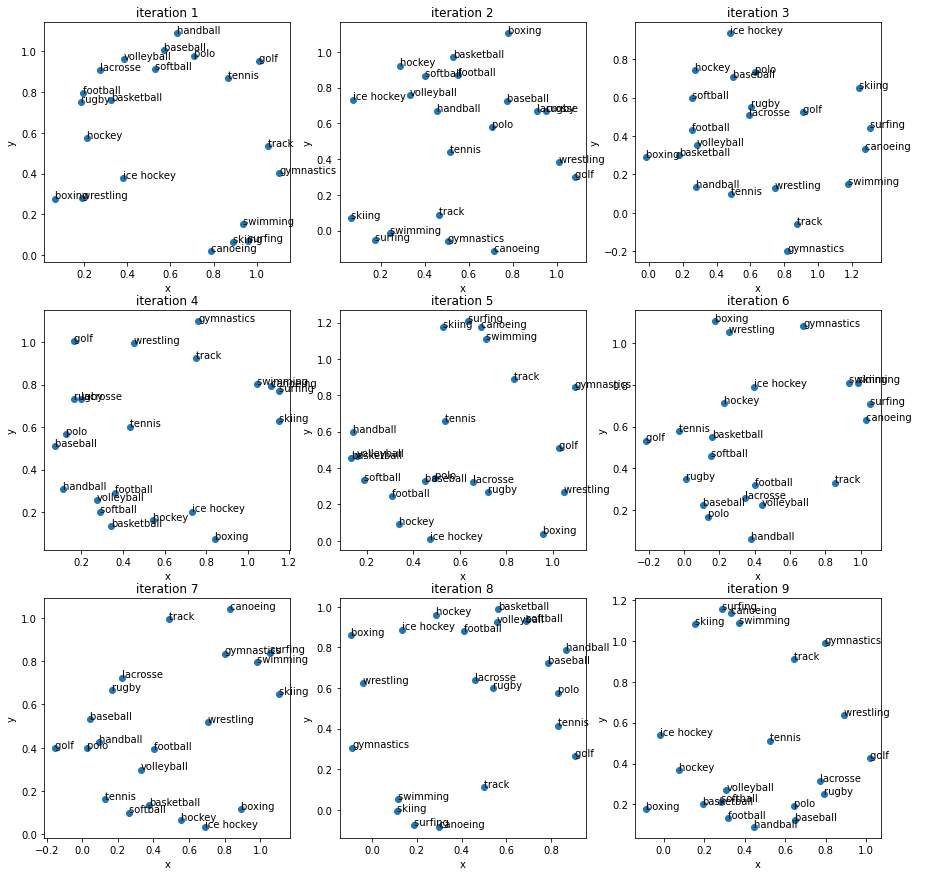

In [17]:
#YOUR CODE HERE

figure, axis = plt.subplots(3, 3, figsize = (15, 15))

counter = 1
final_stress_lst = []
for i in range(3):
    for j in range(3):
        hypo_positions, stress_lst = mds(delta, alpha)
        final_stress_lst.append(stress_lst[-1])
        axis[i, j].scatter(hypo_positions[:, 0], hypo_positions[:, 1])
        for k in range(21):
            axis[i, j].text(hypo_positions[k, 0], hypo_positions[k, 1], sport_names[k])
        axis[i, j].set_title("iteration " + str(counter))
        axis[i, j].set_xlabel("x")
        axis[i, j].set_ylabel("y")
        counter += 1


figure.savefig('PS4_Q7_1.png')

## Q7.2 Best representation [3pts, SOLO]
In another figure, plot the final stress value as a function of the MDS iteration (9) in the previous question. If you wanted to pick the best final representation based on this plot, how would you do it? What criteria would you use? Which iteration is your best?

Enter your answer in gradescope.

Upload PS4_Q7_2.png.

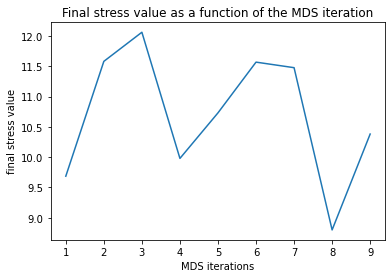

In [18]:
#YOUR CODE HERE

figure, axis = plt.subplots()

iterations = np.arange(1, 10)
axis.plot(iterations, final_stress_lst)
axis.set_xlabel("MDS iterations")
axis.set_ylabel("final stress value")
axis.set_xticks(iterations)
axis.set_title("Final stress value as a function of the MDS iteration")

figure.savefig('PS4_Q7_2.png')

## Q7.3 [4pts, SOLO]
Do your best results agree with your intuitions about how this domain might be organized? Why or why not? Answer in 2-3 sentences. 

Enter your response in gradescope.


## Q8 [5pts, SOLO]

Run MDS 2 times, with 2 different step sizes (α=.02 and  α=.05). Plot Stress over time for each run in the same plot. Don't forget to add a legend,labeling which MDS step size the line refers to, in addition to the usual axis labels and title. What happens if you use a bigger step in your MDS? Why?


Enter your answer in gradescope.

Upload PS4_Q8.png.

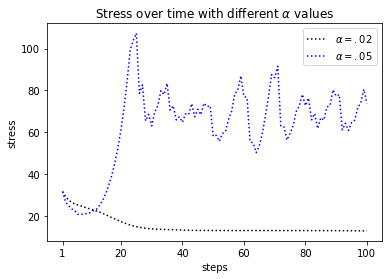

In [21]:
#YOUR CODE HERE

figure, axis = plt.subplots()

# hypo_positions1, stress_lst1 = mds(delta, 0.01)
hypo_positions2, stress_lst2 = mds(delta, 0.02)
hypo_positions5, stress_lst5 = mds(delta, 0.05)
steps = np.arange(1, 100 + 1)

# axis.plot(steps, stress_lst1, 'r:', label = r'$\alpha = .01$')
axis.plot(steps, stress_lst2, 'k:', label = r'$\alpha = .02$')
axis.plot(steps, stress_lst5, 'b:', label = r'$\alpha = .05$')
axis.set_xlabel("steps")
axis.set_ylabel("stress")
axis.set_xticks([1, 20, 40, 60, 80, 100])
axis.set_title("Stress over time with different " + r"$\alpha$" + " values")
plt.legend()


figure.savefig('PS4_Q8.png')

<div style="background-color: #c1f2a5">

# Submission

When you're done with your problem set, do the following:
- Upload your answers in Gradescope's PS4.
- Upload your code as .py file in PS4-code in Gradescope (To convert the notebook into .py file click on File > Download as > Python (.py)).
    



</div>